In [1]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from PIL import PILLOW_VERSION
from PIL import Image
from torch.utils.data import Dataset
import sqlite3
import random

import torch.utils.data as data
import torchvision.models as models
from torchvision import datasets, transforms, utils
from math import ceil

/home/mdelabrassinne/anaconda3/envs/envDeepLearning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mdelabrassinne/anaconda3/envs/envDeepLearning/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/mdelabrassinne/anaconda3/envs/envDeepLearning/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [3]:
!pip install wandb -qU

In [4]:
import wandb


wandb.login()

#wandb.login()
#wandb.init(project='action_spotting', name='mdelabrassinne')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mdelabrassinne (maxdelabrassinne). Use `wandb login --relogin` to force relogin


True

In [5]:
## Class of the dataset

In [6]:
cL = ('Corner', 'Goal', 'Penalty', 'Kick-off', 'Yellow card', 'Red card', 'Yellow->red card')

In [7]:

class FootballDataset(Dataset):    #modifiable
    """
    Class to prepare the data for a neural network in pyTorch. The database is composed of 3 tables:
    - Video: to save the video information
    - Sequence: to save the sequence information labelled with the soccer actions and record the sound of the sequence
    - Image: to save the image information of the sequence
    """
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        image = Image.open(img_path).convert('RGB')
        
        
        if self.transform:
            proba = 1 / (len(self.transform))
            val = random.random()
            current = 0
            for i in range(len(self.transform)):
                if val < current + proba:
                    image = self.transform[i](image)
                    return image, label
            return self.transform[-1](image), label
        else:                
            return image, label

    def get_images(db_path: str, classes: list = ["Corner"], type_: str = "Training", limits: list = {"Corner": None, "NoClass": None}) -> list:
        """
        Connects to the database and returns the images and labels.

        Args:
            db_path (str): Path to the database.
            classes (list, optional): List of classes to be considered. Defaults to ["Corner"].
            type_ (str, optional): Type of the video. Defaults to "Training".
            limits (list, optional): Limits of the number of images per class to be considered. Defaults to [None, None]. If None, all the images are considered.

        Returns:
            list: List of tuples with the image path and the label.
        """
        
        # connect to the database
        conn = sqlite3.connect(db_path)
        c = conn.cursor()

        # get the images and labels
        c.execute("SELECT im.Path, seq.Label FROM IMAGE im INNER JOIN Sequence seq ON im.SequencePath = seq.Path_sequence INNER JOIN VIDEO vid ON seq.VideoPath = vid.Path_video WHERE vid.training_stage = ?", (type_,))

        data = c.fetchall()


        # Get the number of sequence per class
        c.execute("SELECT seq.Label, COUNT(seq.Label) FROM Sequence seq INNER JOIN VIDEO vid ON seq.VideoPath = vid.Path_video WHERE vid.training_stage = ? GROUP BY seq.Label", (type_,))
        seq_classes = c.fetchall()

        conn.close()

        # Get the clever images per class
        im_allowed = {}
        no_class = 0
        for seq in seq_classes:
            if seq[0] in classes:
                if limits[seq[0]] != None:
                    im_per_seq = ceil(limits[seq[0]] / seq[1])
                    im_allowed[seq[0]] = []
                    step = - 24 // im_per_seq
                    for i in range(24, 0, step):
                        im_allowed[seq[0]].append(f"{i}.jpg")
                else:
                    im_allowed[seq[0]] = None
            else:
                no_class += seq[1]

        if limits["NoClass"] != None:
            proba = 1 - limits["NoClass"] / (no_class * 24)
        else:
            proba = 0

        probas = np.random.rand(len(data))
        pred = []
        count = 0
        for i, val in enumerate(data):
            if val[1] in classes:
                if im_allowed[val[1]] == None:
                    pred.append((val[0], val[1]))
                elif val[0].split("/")[-1] in im_allowed[val[1]]:
                    pred.append((val[0], val[1]))
            else:
                if probas[i] > proba:
                    pred.append((val[0], "NoClass"))
                    count += 1
                        
        return np.array(pred)

In [8]:
pHflip = 0.1                                     # probability of applying a horizontal flip
pVflip = 0.05                                     # probability of applying a vertical flip

# next values arbitrarily chosen
br_amount = 0.1                                  # define how much brightness should be jitter
c_amount = 0.1                                   # define how much contrast should be jitter
s_amount = 0.1                                   # define how much saturation should be jitter
h = 0.1                                          # define how much hue should be jitter

pGray = 0.4
pInvert = 0.4
pErasing = 0.1                                  # possible to change the size
deg = 20

# define the transformations to be applied randomly
tr_list = [
    transforms.RandomHorizontalFlip(pHflip),
    transforms.RandomVerticalFlip(pVflip),
    transforms.ColorJitter(brightness= br_amount, contrast=c_amount, saturation=s_amount, hue=h)
]

# apply the transformations with a probability of 90% 
transform = transforms.RandomApply(tr_list, p=0.9)

# compose the full transformation pipeline
transform_full = transforms.Compose([
    transform,
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

tranform1 = transforms.Compose([
    transforms.RandomHorizontalFlip(pHflip),
    transforms.ColorJitter(brightness= br_amount, contrast=c_amount, saturation=s_amount, hue=h),
    transforms.RandomRotation(deg),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),           # modify those values (pour l'instant poids du resnet)
    transforms.RandomErasing(pErasing),
])

transform2 = transforms.Compose([
    transforms.RandomHorizontalFlip(pHflip),
    transforms.RandomGrayscale(pGray),
    transforms.RandomRotation(deg),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),           # modify those values (pour l'instant poids du resnet)
    transforms.RandomErasing(pErasing),
])

transform3 = transforms.Compose([
    transforms.RandomHorizontalFlip(pHflip),
    transforms.RandomInvert(pInvert),
    transforms.RandomRotation(deg),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),           # modify those values (pour l'instant poids du resnet)
    transforms.RandomErasing(pErasing),
])

tr_base = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),           # modify those values
])

trans_lits = [tranform1, transform2, transform3, tr_base]

In [9]:
## see images

In [10]:
def show_images(img):
    plt.imshow(transforms.functional.to_pil_image(img))
    plt.show()

In [11]:
limits_train = {'Corner':10000, 'Goal':12000, 'Penalty':None, 'Kick-off':None, 'Yellow card':9000, 'Red card':1000, 'Yellow->red card':1000, 'NoClass':12000}
limits_test = {'Corner':500, 'Goal':500, 'Penalty':500, 'Kick-off':500, 'Yellow card':500, 'Red card':500, 'Yellow->red card':500, 'NoClass':500}

In [12]:
data_list = FootballDataset.get_images(db_path="/scratch/users/mdelabrassinne/Database/SoccerDB.db", classes = cL, limits = limits_train, type_="Training")

In [13]:
classes_nb = {'Corner':0, 'Goal':0, 'Penalty':0, 'Kick-off':0, 'Yellow card':0, 'Red card':0, 'Yellow->red card':0, 'NoClass':0}
for val in data_list:
    classes_nb[val[1]] += 1
print(classes_nb)
    

{'Corner': 12272, 'Goal': 9616, 'Penalty': 3000, 'Kick-off': 12750, 'Yellow card': 9624, 'Red card': 528, 'Yellow->red card': 408, 'NoClass': 12606}


### Define the dataset and the dataloader

Lopp
End loop


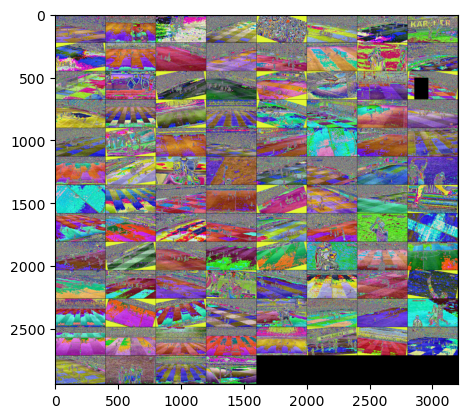

Penalty Kick-off Yellow card Goal Yellow->red card Penalty NoClass Corner Penalty Kick-off Penalty NoClass Goal Yellow card Yellow card Corner Penalty Kick-off Corner Penalty Penalty Corner NoClass Goal Goal Kick-off Kick-off Kick-off Corner Corner Yellow card Goal Corner NoClass NoClass Corner Penalty Kick-off Goal NoClass Kick-off NoClass NoClass Yellow card Goal NoClass Corner Yellow card Kick-off NoClass Goal Yellow card Penalty Penalty Penalty Kick-off NoClass Penalty Goal Goal Penalty Penalty NoClass Kick-off NoClass Goal Penalty NoClass NoClass NoClass Kick-off Yellow card Corner Corner Penalty Yellow->red card Penalty Kick-off Corner Yellow card Kick-off Yellow card Kick-off Penalty Corner Corner Goal NoClass Kick-off Kick-off Kick-off Kick-off Kick-off Yellow card Kick-off Yellow card Goal Yellow card Kick-off Corner


In [14]:

dataLearning = FootballDataset.get_images(db_path="/scratch/users/mdelabrassinne/Database/SoccerDB.db",classes = cL,limits = limits_train, type_="Training")
dataValidation = FootballDataset.get_images(db_path="/scratch/users/mdelabrassinne/Database/SoccerDB.db",classes = cL, limits = limits_test, type_="Validation")
dataTest = FootballDataset.get_images(db_path="/scratch/users/mdelabrassinne/Database/SoccerDB.db",classes = cL,limits = limits_test, type_="Test")

print("Lopp")
# Augment penalty
dataLearning = list(dataLearning)
for val in data_list:
    if val[1] == "Penalty":
        dataLearning.append((val[0], val[1]))
        dataLearning.append((val[0], val[1]))
        dataLearning.append((val[0], val[1]))

dataLearning = np.array(dataLearning)

print("End loop")
        
datasetLearning = FootballDataset(data_list=dataLearning, transform=trans_lits)
datasetValidation = FootballDataset(data_list=dataValidation, transform=[tr_base])            # no augmentation for the validation or test set
datasetTest = FootballDataset(data_list=dataTest, transform=[tr_base])


loaderLearning = data.DataLoader(datasetLearning, batch_size = 100, shuffle= True, num_workers = 2)
loaderValidation = data.DataLoader(datasetValidation, batch_size = 100, shuffle= True, num_workers = 2)
loaderTest = data.DataLoader(datasetTest, batch_size = 100, shuffle= True, num_workers = 2)



images, labels = next(iter(loaderLearning))    # (perso) check ma petite faute dans le devoir 2
show_images(utils.make_grid(images))  # should look weird due to normalization
print(*[l for l in labels])

In [15]:
classes_nb = {'Corner':0, 'Goal':0, 'Penalty':0, 'Kick-off':0, 'Yellow card':0, 'Red card':0, 'Yellow->red card':0, 'NoClass':0}
for val in dataLearning:
    classes_nb[val[1]] += 1
print(classes_nb)

{'Corner': 12272, 'Goal': 9616, 'Penalty': 12000, 'Kick-off': 12750, 'Yellow card': 9624, 'Red card': 528, 'Yellow->red card': 408, 'NoClass': 12458}


In [16]:
classes_nb = {'Corner':0, 'Goal':0, 'Penalty':0, 'Kick-off':0, 'Yellow card':0, 'Red card':0, 'Yellow->red card':0, 'NoClass':0}
for val in dataValidation:
    classes_nb[val[1]] += 1
print(classes_nb)

{'Corner': 742, 'Goal': 636, 'Penalty': 432, 'Kick-off': 464, 'Yellow card': 620, 'Red card': 72, 'Yellow->red card': 96, 'NoClass': 507}


In [17]:
classes_nb = {'Corner':0, 'Goal':0, 'Penalty':0, 'Kick-off':0, 'Yellow card':0, 'Red card':0, 'Yellow->red card':0, 'NoClass':0}
for val in dataTest:
    classes_nb[val[1]] += 1
print(classes_nb)

{'Corner': 760, 'Goal': 658, 'Penalty': 408, 'Kick-off': 528, 'Yellow card': 564, 'Red card': 216, 'Yellow->red card': 72, 'NoClass': 530}


In [18]:
device = 'cuda'
torch.cuda.empty_cache()

## resnet 

In [19]:
model = models.efficientnet_b7(weights="IMAGENET1K_V1")

#resnet not trained later 
for param in model.parameters():
    param.requires_grad = False

In [20]:
# MLP for classification

num_features = model.classifier[-1].in_features
mlp = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(p=0.8),
    nn.Linear(512, 64),
    nn.ReLU(),
    nn.Dropout(p=0.8),
    nn.Linear(64, 6),
    #nn.Softmax(dim=1)
)

model.classifier = mlp

In [21]:
v = ['Goal', 'Corner', 'Penalty', 'Kick-off', 'Yellow card', 'Red card', 'Yellow->red card', 'NoClass']
c = ['Corner', 'Goal', 'Penalty', 'Kick-off','card', 'NoClass']

def toTens(labels, classes = c):
    res = [classes.index(labels[j]) if labels[j] in c else 4 for j in range(len(labels))]
    return torch.tensor(res)
    
toTens(v, c)

tensor([1, 0, 2, 3, 4, 4, 4, 5])

In [22]:
epochs=30
n_classes=6
learning_rate=0.0001
decay = .01

In [23]:
def make():
    # Make the model
    mod = model.to(device)                                     #model variable globale

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(mod.parameters(), lr=learning_rate, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold  = .01, threshold_mode = "abs", mode='max', factor=0.2, patience=5)
    
    return criterion, optimizer, scheduler

In [24]:
def train_log(loss, example_ct, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
    print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")

In [25]:
def test():
    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        correct, total = 0, 0
        correct_class = [0 for i in range(n_classes)]
        total_class = [0 for i in range(n_classes)]
        for images, labels in loaderValidation:
            
            labels = toTens(labels)
            
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Compute accuracy per class
            for i in range(len(labels)):
                label = labels[i]
                pred = predicted[i]
                total_class[label] += 1
                if label == pred:
                    correct_class[label] += 1
            torch.cuda.empty_cache()

        
        test_acc = 0.
        for i in range(n_classes):
            test_acc += correct_class[i] / total_class[i]
            wandb.log({f"Accuracy of {c[i]}": correct_class[i] / total_class[i]})
        test_acc /= n_classes
        
        print(f"Accuracy of the model on the {total} " +
              f"test images: {test_acc:%}")
        
        wandb.log({"test_accuracy": test_acc})

        
        
    # Save the model in the exchangeable ONNX format
    torch.onnx.export(model, images, "model.onnx")
    wandb.save("model.onnx")
    return correct / total

In [26]:
def train(criterion, optimizer, scheduler, test_set = True):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    # Run training and track with wandb
    total_batches = len(loaderLearning) * epochs
    example_ct = 0  # number of examples seen
    batch_ct = 0
        
    for epoch in tqdm(range(epochs)):
        for images, labels in loaderLearning:
            
            #images = images.to(device)
            labels = toTens(labels)
            
            loss = train_batch(images, labels, model, optimizer, criterion)
            example_ct +=  len(images)
            batch_ct += 1

            # Report metrics every 25th batch
            if ((batch_ct + 1) % 25) == 0:
                train_log(loss, example_ct, epoch)
                
            torch.cuda.empty_cache()

        if test_set:
            acc = test()
            scheduler.step(acc)
            


def train_batch(images, labels, model, optimizer, criterion):
    
    images, labels = images.to(device), labels.to(device)
    # Forward pass ➡
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward pass ⬅
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss

In [27]:
config = dict(
    epochs=30,
    classes=6,
    learning_rate=0.0001,
    loaderLearning = loaderLearning,
    loaderValidation = loaderValidation,
    loaderTest = loaderTest)

In [28]:
def model_pipeline(config=None, project_name="action_spotting"):

    # tell wandb to get started
    with wandb.init(config=config):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # data, and optimization problem
      criterion, optimizer, scheduler  = make()  
      # and use them to train the model
      train(criterion, optimizer, scheduler)

    return model

In [ ]:
sweep_config = {
    "name": "action_spotting",
    "method": "random",
    "metric": {"name": "test_accuracy", "goal": "maximize"},
    "parameters":
    {
        "learning_rate": {"values": [0.01]},
        "batch_size": {"values": [100]},
    }
}
# sweep_id = wandb.sweep(sweep_config, project="action_spotting")

wandb.login()

model = model_pipeline(config)
torch.save(model.state_dict(), "model_efficientNetB7.pt")

  0%|          | 0/30 [00:00<?, ?it/s]

Loss after 02400 examples: 1.786
Loss after 04900 examples: 1.786
Loss after 07400 examples: 1.777
Loss after 09900 examples: 1.722
Loss after 12400 examples: 1.712
Loss after 14900 examples: 1.747
Loss after 17400 examples: 1.662
Loss after 19900 examples: 1.594
Loss after 22400 examples: 1.567
Loss after 24900 examples: 1.636
Loss after 27400 examples: 1.527
Loss after 29900 examples: 1.467
Loss after 32400 examples: 1.584
Loss after 34900 examples: 1.464
Loss after 37400 examples: 1.410
Loss after 39900 examples: 1.399
Loss after 42400 examples: 1.285
Loss after 44900 examples: 1.254
Loss after 47400 examples: 1.414
Loss after 49900 examples: 1.559
Loss after 52400 examples: 1.330
Loss after 54900 examples: 1.266
Loss after 57400 examples: 1.206
Loss after 59900 examples: 1.302
Loss after 62400 examples: 1.330
Loss after 64900 examples: 1.245
Loss after 67400 examples: 1.319
Accuracy of the model on the 3569 test images: 58.310065%


  3%|▎         | 1/30 [21:03<10:10:48, 1263.76s/it]

Loss after 69856 examples: 1.239
Loss after 72356 examples: 1.115
Loss after 74856 examples: 1.054
Loss after 77356 examples: 0.927
Loss after 79856 examples: 0.848
Loss after 82356 examples: 0.862
Loss after 84856 examples: 0.842
Loss after 87356 examples: 0.921
Loss after 89856 examples: 0.787
Loss after 92356 examples: 0.930
Loss after 94856 examples: 0.820
Loss after 97356 examples: 0.836
Loss after 99856 examples: 0.843
Loss after 102356 examples: 0.813
Loss after 104856 examples: 0.780
Loss after 107356 examples: 0.813
Loss after 109856 examples: 0.863
Loss after 112356 examples: 0.809
Loss after 114856 examples: 0.769
Loss after 117356 examples: 0.822
Loss after 119856 examples: 0.781
Loss after 122356 examples: 0.631
Loss after 124856 examples: 0.703
Loss after 127356 examples: 0.815
Loss after 129856 examples: 0.822
Loss after 132356 examples: 0.769
Loss after 134856 examples: 0.846
Loss after 137356 examples: 0.855
Accuracy of the model on the 3569 test images: 67.803030%


  7%|▋         | 2/30 [40:45<9:27:21, 1215.78s/it] 

Loss after 139812 examples: 0.711
Loss after 142312 examples: 0.753
Loss after 144812 examples: 0.664
Loss after 147312 examples: 0.682
Loss after 149812 examples: 0.656
Loss after 152312 examples: 0.788
Loss after 154812 examples: 0.669
Loss after 157312 examples: 0.636
Loss after 159812 examples: 0.686
Loss after 162312 examples: 0.827
Loss after 164812 examples: 0.656
Loss after 167312 examples: 0.647
Loss after 169812 examples: 0.804
Loss after 172312 examples: 0.824
Loss after 174812 examples: 0.671
Loss after 177312 examples: 0.700
Loss after 179812 examples: 0.602
Loss after 182312 examples: 0.677
Loss after 184812 examples: 0.577
Loss after 187312 examples: 0.587
Loss after 189812 examples: 0.778
Loss after 192312 examples: 0.712
Loss after 194812 examples: 0.705
Loss after 197312 examples: 0.696
Loss after 199812 examples: 0.548
Loss after 202312 examples: 0.596
Loss after 204812 examples: 0.584
Loss after 207312 examples: 0.534
Accuracy of the model on the 3569 test images: 6

 10%|█         | 3/30 [1:00:29<9:00:31, 1201.15s/it]

Loss after 209768 examples: 0.609
Loss after 212268 examples: 0.550
Loss after 214768 examples: 0.745
Loss after 217268 examples: 0.376
Loss after 219768 examples: 0.513
Loss after 222268 examples: 0.533
Loss after 224768 examples: 0.476
Loss after 227268 examples: 0.752
Loss after 229768 examples: 0.551
Loss after 232268 examples: 0.453
Loss after 234768 examples: 0.517
Loss after 237268 examples: 0.569
Loss after 239768 examples: 0.546
Loss after 242268 examples: 0.501
Loss after 244768 examples: 0.434
Loss after 247268 examples: 0.440
Loss after 249768 examples: 0.598
Loss after 252268 examples: 0.507
Loss after 254768 examples: 0.553
Loss after 257268 examples: 0.542
Loss after 259768 examples: 0.615
Loss after 262268 examples: 0.603
Loss after 264768 examples: 0.532
Loss after 267268 examples: 0.543
Loss after 269768 examples: 0.513
Loss after 272268 examples: 0.453
Loss after 274768 examples: 0.476
Loss after 277268 examples: 0.379
Accuracy of the model on the 3569 test images: 6

 13%|█▎        | 4/30 [1:20:10<8:37:00, 1193.09s/it]

Loss after 279724 examples: 0.625
Loss after 282224 examples: 0.487
Loss after 284724 examples: 0.446
Loss after 287224 examples: 0.522
Loss after 289724 examples: 0.463
Loss after 292224 examples: 0.578
Loss after 294724 examples: 0.449
Loss after 297224 examples: 0.302
Loss after 299724 examples: 0.601
Loss after 302224 examples: 0.409
Loss after 304724 examples: 0.455
Loss after 307224 examples: 0.389
Loss after 309724 examples: 0.442
Loss after 312224 examples: 0.463
Loss after 314724 examples: 0.501
Loss after 317224 examples: 0.455
Loss after 319724 examples: 0.362
Loss after 322224 examples: 0.521
Loss after 324724 examples: 0.547
Loss after 327224 examples: 0.482
Loss after 329724 examples: 0.648
Loss after 332224 examples: 0.430
Loss after 334724 examples: 0.358
Loss after 337224 examples: 0.466
Loss after 339724 examples: 0.366
Loss after 342224 examples: 0.406
Loss after 344724 examples: 0.453
Loss after 347224 examples: 0.525
Accuracy of the model on the 3569 test images: 6

/home/mdelabrassinne/anaconda3/envs/envDeepLearning/lib/python3.9/site-packages/wandb/wandb_torch.py:303: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return tensor.shape == torch.Size([0]) or (~torch.isfinite(tensor)).all().item()
/home/mdelabrassinne/anaconda3/envs/envDeepLearning/lib/python3.9/site-packages/wandb/wandb_torch.py:303: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return tensor.shape == torch.Size([0]) or (~torch.isfinite(tensor)).all().item()
/home/mdelabrassinne/anaconda3/envs/envDeepLearning/lib/python3.9/site-packages/wandb/wandb_t

Loss after 349680 examples: 0.459
Loss after 352180 examples: 0.363
Loss after 354680 examples: 0.325
Loss after 357180 examples: 0.459
Loss after 359680 examples: 0.486
Loss after 362180 examples: 0.470
Loss after 364680 examples: 0.484
Loss after 367180 examples: 0.360
Loss after 369680 examples: 0.303
Loss after 372180 examples: 0.499
Loss after 374680 examples: 0.386
Loss after 377180 examples: 0.314
Loss after 379680 examples: 0.445
Loss after 382180 examples: 0.346
Loss after 384680 examples: 0.562
Loss after 387180 examples: 0.344
Loss after 389680 examples: 0.336
Loss after 392180 examples: 0.357
Loss after 394680 examples: 0.371
Loss after 397180 examples: 0.409
Loss after 399680 examples: 0.483
Loss after 402180 examples: 0.312
Loss after 404680 examples: 0.375
Loss after 407180 examples: 0.433
Loss after 409680 examples: 0.436
Loss after 412180 examples: 0.378
Loss after 414680 examples: 0.464
Loss after 417180 examples: 0.326
Accuracy of the model on the 3569 test images: 6

 20%|██        | 6/30 [1:59:38<7:55:01, 1187.57s/it]

Loss after 419636 examples: 0.515
Loss after 422136 examples: 0.418
Loss after 424636 examples: 0.373
Loss after 427136 examples: 0.378
Loss after 429636 examples: 0.327
Loss after 432136 examples: 0.367
Loss after 434636 examples: 0.301
Loss after 437136 examples: 0.265
Loss after 439636 examples: 0.338
Loss after 442136 examples: 0.353
Loss after 444636 examples: 0.371
Loss after 447136 examples: 0.263
Loss after 449636 examples: 0.395
Loss after 452136 examples: 0.298
Loss after 454636 examples: 0.362
Loss after 457136 examples: 0.349
Loss after 459636 examples: 0.366
Loss after 462136 examples: 0.317
Loss after 464636 examples: 0.471
Loss after 467136 examples: 0.340
Loss after 469636 examples: 0.246
Loss after 472136 examples: 0.465
Loss after 474636 examples: 0.330
Loss after 477136 examples: 0.366
Loss after 479636 examples: 0.355
Loss after 482136 examples: 0.407
Loss after 484636 examples: 0.382
Loss after 487136 examples: 0.413
Accuracy of the model on the 3569 test images: 6

 23%|██▎       | 7/30 [2:19:26<7:35:19, 1187.80s/it]

Loss after 489592 examples: 0.348
Loss after 492092 examples: 0.415
Loss after 494592 examples: 0.488
Loss after 497092 examples: 0.366
Loss after 499592 examples: 0.297
Loss after 502092 examples: 0.364
Loss after 504592 examples: 0.305
Loss after 507092 examples: 0.265
Loss after 509592 examples: 0.364
Loss after 512092 examples: 0.349
Loss after 514592 examples: 0.332
Loss after 517092 examples: 0.372
Loss after 519592 examples: 0.333
Loss after 522092 examples: 0.287
Loss after 524592 examples: 0.247
Loss after 527092 examples: 0.298
Loss after 529592 examples: 0.527
Loss after 532092 examples: 0.306
Loss after 534592 examples: 0.287
Loss after 537092 examples: 0.272
Loss after 539592 examples: 0.405
Loss after 542092 examples: 0.377
Loss after 544592 examples: 0.235
Loss after 547092 examples: 0.247
Loss after 549592 examples: 0.321
Loss after 552092 examples: 0.213
Loss after 554592 examples: 0.285
Loss after 557092 examples: 0.195
Accuracy of the model on the 3569 test images: 6

 27%|██▋       | 8/30 [2:39:54<7:20:11, 1200.54s/it]

Loss after 559548 examples: 0.308
Loss after 562048 examples: 0.332
Loss after 564548 examples: 0.256
Loss after 567048 examples: 0.223
Loss after 569548 examples: 0.354
Loss after 1041784 examples: 0.256
Loss after 1044284 examples: 0.201
Accuracy of the model on the 3569 test images: 66.598603%


 50%|█████     | 15/30 [5:04:04<5:08:38, 1234.54s/it]

Loss after 1046740 examples: 0.153
Loss after 1049240 examples: 0.236
Loss after 1051740 examples: 0.209
Loss after 1054240 examples: 0.198
Loss after 1056740 examples: 0.204
Loss after 1059240 examples: 0.241
Loss after 1061740 examples: 0.187
Loss after 1064240 examples: 0.292
Loss after 1066740 examples: 0.197
Loss after 1069240 examples: 0.178
Loss after 1071740 examples: 0.237
Loss after 1074240 examples: 0.146
Loss after 1076740 examples: 0.247
Loss after 1079240 examples: 0.228
Loss after 1081740 examples: 0.308
Loss after 1084240 examples: 0.298
Loss after 1086740 examples: 0.201
Loss after 1089240 examples: 0.237
Loss after 1091740 examples: 0.222
Loss after 1094240 examples: 0.207
Loss after 1096740 examples: 0.183
Loss after 1099240 examples: 0.212
Loss after 1101740 examples: 0.232
Loss after 1104240 examples: 0.250
Loss after 1106740 examples: 0.336
Loss after 1109240 examples: 0.211
Loss after 1111740 examples: 0.159
Loss after 1114240 examples: 0.241
Accuracy of the mode

 53%|█████▎    | 16/30 [5:24:16<4:46:28, 1227.75s/it]

Loss after 1116696 examples: 0.143
Loss after 1119196 examples: 0.237
Loss after 1121696 examples: 0.172
Loss after 1124196 examples: 0.240
Loss after 1126696 examples: 0.326
Loss after 1129196 examples: 0.280
Loss after 1131696 examples: 0.274
Loss after 1134196 examples: 0.378
Loss after 1136696 examples: 0.264
Loss after 1139196 examples: 0.292
Loss after 1141696 examples: 0.126
Loss after 1144196 examples: 0.337
Loss after 1146696 examples: 0.207
Loss after 1149196 examples: 0.197
Loss after 1151696 examples: 0.294
Loss after 1154196 examples: 0.299
Loss after 1156696 examples: 0.193
Loss after 1159196 examples: 0.155
Loss after 1161696 examples: 0.300
Loss after 1164196 examples: 0.194
Loss after 1166696 examples: 0.258
Loss after 1169196 examples: 0.179
Loss after 1171696 examples: 0.244
Loss after 1174196 examples: 0.176
Loss after 1176696 examples: 0.209
Loss after 1179196 examples: 0.161
Loss after 1181696 examples: 0.182
Loss after 1184152 examples: 0.198
Accuracy of the mode

 57%|█████▋    | 17/30 [5:44:25<4:24:47, 1222.09s/it]

Loss after 1186652 examples: 0.231
Loss after 1189152 examples: 0.387
Loss after 1191652 examples: 0.266
Loss after 1194152 examples: 0.256
Loss after 1196652 examples: 0.393
Loss after 1199152 examples: 0.220
Loss after 1201652 examples: 0.194
